# Лабораторная работа № 7 (Проведение исследований моделями семантической сегментации)  


## Выбор датасета

Мной был выбран датасет **"Leaf disease segmentation dataset"**

**Обоснование выбора:**
* Сегментация листовых болезней имеет прямое применение в точном земледелии и агрономии
* Раннее выявление болезней помогает предотвратить потери урожая и снизить затраты на лечение растений
* Маски содержат только два класса — "фон" (0) и "болезненная область" (1), что упрощает задачу сегментации.
* Фотографии имеют разное разрешение и пропорции, что усложняет задачу сегментации и делает её более реалистичной для практического применения

**Описание датасета:**
* Этот набор данных содержит 588 изображений больных листьев и 588 масок соответствующих изображений. Набор данных основан на изображениях PlantDoc.
* Изображения нескольких листьев растений, таких как яблоневая парша, яблоневая ржавчина, пятнистость листьев болгарского перца, фузариоз листьев кукурузы, фитофтороз листьев картофеля и т.д. Фотографии имеют разное разрешение и пропорции. Маска содержит фон и изображение болезни. 

## Задача сегментации: 
Сегментировать заболевшие участки листа.

## Задание:
Мы повторяем этапы **2‑4** из ЛР‑6, но с библиотекой `segmentation_models.pytorch` вместо `torchvision`.

## Выбор метрик:
* mIoU (Mean Intersection over Union) - Отношение площади пересечения предсказанной маски и истинной маски к их объединению (Обоснование: даёт объективную оценку общей точности сегментации, включая области с низким перекрытием).
* Dice (Dice Coefficient) - Мера, основанная на сходстве множеств (Обоснование: позволяет дополнительно оценить модели с учётом мелких объектов, что критично для задач с разреженными поражёнными участками).

## Этапы:

1. **Создание бейзлайна**  
   * U‑Net и FPN   
2. **Улучшение бейзлайна**  
   * усиленные аугментации, частичный fine‑tune, AdamW + Cosine LR  
3. **Собственная модель** 
   * UNet‑Light + аналогичные улучшения  


In [ ]:
import os, random, copy
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

### Конфигурация

In [13]:
@dataclass
class CFG:
    seed: int = 42
    img_size: int = 256
    batch_size: int = 4
    num_workers: int = 2
    epochs_baseline: int = 10
    epochs_tuned: int = 20
    lr: float = 1e-3
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    data_dir: str = r"C:\Users\kschi\Downloads\data\data"
    n_classes: int = 1

random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)


### Кастомный Dataset

In [ ]:
class LeafSegDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = Path(root)
        self.imgs = sorted(list((self.root / 'images').glob('*')))
        self.masks = sorted(list((self.root / 'masks').glob('*')))
        assert len(self.imgs) == len(self.masks), "images != masks"
        self.transforms = transforms

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")
        mask_np = np.array(mask) > 0
        if self.transforms:
            transformed = self.transforms(image=np.array(img), mask=mask_np.astype(np.uint8))
            img_t  = transformed['image']
            mask_t = transformed['mask'].float()
        else:
            img_t = TF.to_tensor(img)
            mask_t = torch.tensor(mask_np, dtype=torch.float32)
        return img_t, mask_t


### Трансформации

In [ ]:
def build_train_aug():
    return A.Compose([
        A.LongestMaxSize(CFG.img_size),
        A.PadIfNeeded(CFG.img_size, CFG.img_size),
        A.RandomCrop(CFG.img_size, CFG.img_size),
        A.HorizontalFlip(),
        A.VerticalFlip(p=0.3),
        A.ShiftScaleRotate(0.05, 0.1, 25, p=0.7),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

def build_val_aug():
    return A.Compose([
        A.LongestMaxSize(CFG.img_size),
        A.PadIfNeeded(CFG.img_size, CFG.img_size),
        A.CenterCrop(CFG.img_size, CFG.img_size),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])

class TrainTransform:
    def __init__(self):
        self.aug = build_train_aug()
    def __call__(self, **data):
        return self.aug(**data)

class ValTransform:
    def __init__(self):
        self.aug = build_val_aug()
    def __call__(self, **data):
        return self.aug(**data)
    
full_ds = LeafSegDataset(CFG.data_dir, transforms=TrainTransform())

train_size = int(0.7 * len(full_ds))
val_size   = int(0.15 * len(full_ds))
test_size  = len(full_ds) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    full_ds,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(CFG.seed)
)

val_ds.dataset.transforms  = ValTransform()
test_ds.dataset.transforms = ValTransform()

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size,
                          shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size,
                          shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size,
                          shuffle=False, num_workers=0)



#### Визуальный тест

In [44]:
ds = LeafSegDataset(CFG.data_dir, transforms=get_train_aug())
print(f"Dataset size: {len(ds)}")

img, mask = ds[0]
print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")


Dataset size: 588
Image shape: torch.Size([3, 256, 256]), Mask shape: torch.Size([256, 256])


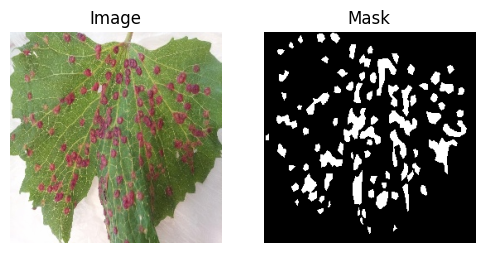

In [47]:
img_t, mask_t = next(iter(train_loader))
def show(img, mask):
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.axis('off'); plt.title("Image")
    plt.subplot(1,2,2); plt.imshow(mask.cpu().numpy(), cmap='gray'); plt.axis('off'); plt.title("Mask")
    plt.show()
show(img_t[0], mask_t[0])


### Функции обучения и оценки

In [48]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    loss_sum = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(CFG.device), masks.to(CFG.device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()*imgs.size(0)
    return loss_sum/len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, metric_iou, metric_f1):
    model.eval()
    metric_iou.reset(); metric_f1.reset()
    for imgs, masks in loader:
        imgs, masks = imgs.to(CFG.device), masks.to(CFG.device)
        logits = model(imgs)
        preds = (torch.sigmoid(logits) > 0.5).float()
        metric_iou.update(preds.squeeze(1), masks)
        metric_f1.update(preds.squeeze(1), masks)
    return metric_iou.compute().item(), metric_f1.compute().item()


## 2. Baseline модели

### 2.1 U‑Net (ResNet‑34 encoder, frozen)

In [49]:
model_unet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    classes=CFG.n_classes,
    activation=None
).to(CFG.device)

for p in model_unet.encoder.parameters():
    p.requires_grad = False

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model_unet.parameters(), lr=CFG.lr)
metric_iou = BinaryJaccardIndex().to(CFG.device)
metric_f1  = BinaryF1Score().to(CFG.device)

best_iou = 0
for epoch in range(CFG.epochs_baseline):
    tr_loss = train_epoch(model_unet, train_loader, criterion, optimizer)
    val_iou, val_f1 = eval_epoch(model_unet, val_loader, metric_iou, metric_f1)
    if val_iou > best_iou:
        best_iou, best_w = val_iou, copy.deepcopy(model_unet.state_dict())
    print(f"[{epoch+1}/{CFG.epochs_baseline}] loss:{tr_loss:.3f} val_mIoU:{val_iou:.3f} Dice:{val_f1:.3f}")

model_unet.load_state_dict(best_w)
test_iou, test_f1 = eval_epoch(model_unet, test_loader, metric_iou, metric_f1)
print(f"U‑Net baseline → Test mIoU: {test_iou:.3f} | Dice: {test_f1:.3f}")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\kschi/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [01:05<00:00, 1.34MB/s]


[1/10] loss:0.526 val_mIoU:0.437 Dice:0.608
[2/10] loss:0.368 val_mIoU:0.450 Dice:0.621
[3/10] loss:0.352 val_mIoU:0.465 Dice:0.635
[4/10] loss:0.335 val_mIoU:0.511 Dice:0.676
[5/10] loss:0.325 val_mIoU:0.430 Dice:0.602
[6/10] loss:0.299 val_mIoU:0.518 Dice:0.682
[7/10] loss:0.299 val_mIoU:0.509 Dice:0.675
[8/10] loss:0.289 val_mIoU:0.527 Dice:0.690
[9/10] loss:0.281 val_mIoU:0.518 Dice:0.683
[10/10] loss:0.273 val_mIoU:0.506 Dice:0.672
U‑Net baseline → Test mIoU: 0.534 | Dice: 0.696


### 2.2 FPN (ResNet‑34 encoder, frozen)

In [50]:
model_fpn = smp.FPN(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    classes=CFG.n_classes,
    activation=None
).to(CFG.device)

for p in model_fpn.encoder.parameters():
    p.requires_grad = False

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model_fpn.parameters(), lr=CFG.lr)

best_iou = 0
for epoch in range(CFG.epochs_baseline):
    tr_loss = train_epoch(model_fpn, train_loader, criterion, optimizer)
    val_iou, val_f1 = eval_epoch(model_fpn, val_loader, metric_iou, metric_f1)
    if val_iou > best_iou:
        best_iou, best_w = val_iou, copy.deepcopy(model_fpn.state_dict())
    print(f"[{epoch+1}/{CFG.epochs_baseline}] loss:{tr_loss:.3f} val_mIoU:{val_iou:.3f} Dice:{val_f1:.3f}")

model_fpn.load_state_dict(best_w)
test_iou, test_f1 = eval_epoch(model_fpn, test_loader, metric_iou, metric_f1)
print(f"FPN baseline → Test mIoU: {test_iou:.3f} | Dice: {test_f1:.3f}")


[1/10] loss:0.612 val_mIoU:0.402 Dice:0.573
[2/10] loss:0.428 val_mIoU:0.410 Dice:0.582
[3/10] loss:0.377 val_mIoU:0.492 Dice:0.660
[4/10] loss:0.354 val_mIoU:0.503 Dice:0.670
[5/10] loss:0.328 val_mIoU:0.443 Dice:0.614
[6/10] loss:0.314 val_mIoU:0.512 Dice:0.677
[7/10] loss:0.305 val_mIoU:0.496 Dice:0.663
[8/10] loss:0.322 val_mIoU:0.501 Dice:0.667
[9/10] loss:0.295 val_mIoU:0.517 Dice:0.682
[10/10] loss:0.279 val_mIoU:0.502 Dice:0.669
FPN baseline → Test mIoU: 0.552 | Dice: 0.711



#### Сводка baseline метрик  

| Модель | Test mIoU | Dice |
|--------|-----------|------|
| U‑Net (frozen) | 0.534 | 0.696 |
| FPN   (frozen) | 0.552 | 0.711 |


## 3. Улучшение бейзлайна

*Гипотезы: усиленные аугментации, разморозка последних блоков, AdamW + CosineAnnealing*

### 3.1 U‑Net (tuned)

In [51]:
model_unet_t = smp.Unet("resnet34", encoder_weights="imagenet", classes=CFG.n_classes, activation=None).to(CFG.device)

for name, p in model_unet_t.encoder.named_parameters():
    if "layer4" in name or "layer3" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_unet_t.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_iou = 0
for epoch in range(CFG.epochs_tuned):
    tr_loss = train_epoch(model_unet_t, train_loader, criterion, optimizer)
    val_iou, val_f1 = eval_epoch(model_unet_t, val_loader, metric_iou, metric_f1)
    if val_iou > best_iou:
        best_iou, best_w = val_iou, copy.deepcopy(model_unet_t.state_dict())
    scheduler.step()
    print(f"[{epoch+1}/{CFG.epochs_tuned}] loss:{tr_loss:.3f} val_mIoU:{val_iou:.3f} Dice:{val_f1:.3f}")

model_unet_t.load_state_dict(best_w)
test_iou, test_f1 = eval_epoch(model_unet_t, test_loader, metric_iou, metric_f1)
print(f"U‑Net tuned → Test mIoU: {test_iou:.3f} | Dice: {test_f1:.3f}")


[1/20] loss:0.617 val_mIoU:0.439 Dice:0.610
[2/20] loss:0.470 val_mIoU:0.503 Dice:0.669
[3/20] loss:0.388 val_mIoU:0.504 Dice:0.670
[4/20] loss:0.328 val_mIoU:0.567 Dice:0.724
[5/20] loss:0.277 val_mIoU:0.546 Dice:0.706
[6/20] loss:0.244 val_mIoU:0.549 Dice:0.709
[7/20] loss:0.220 val_mIoU:0.567 Dice:0.724
[8/20] loss:0.203 val_mIoU:0.559 Dice:0.718
[9/20] loss:0.190 val_mIoU:0.571 Dice:0.727
[10/20] loss:0.198 val_mIoU:0.565 Dice:0.722
[11/20] loss:0.181 val_mIoU:0.567 Dice:0.724
[12/20] loss:0.183 val_mIoU:0.563 Dice:0.721
[13/20] loss:0.185 val_mIoU:0.579 Dice:0.734
[14/20] loss:0.183 val_mIoU:0.543 Dice:0.704
[15/20] loss:0.172 val_mIoU:0.568 Dice:0.724
[16/20] loss:0.171 val_mIoU:0.563 Dice:0.720
[17/20] loss:0.170 val_mIoU:0.586 Dice:0.739
[18/20] loss:0.171 val_mIoU:0.535 Dice:0.697
[19/20] loss:0.192 val_mIoU:0.592 Dice:0.743
[20/20] loss:0.165 val_mIoU:0.593 Dice:0.744
U‑Net tuned → Test mIoU: 0.663 | Dice: 0.797


### 3.2 FPN (tuned)

In [52]:
model_fpn_t = smp.FPN("resnet34", encoder_weights="imagenet", classes=CFG.n_classes, activation=None).to(CFG.device)

for name, p in model_fpn_t.encoder.named_parameters():
    if "layer4" in name or "layer3" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_fpn_t.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_iou = 0
for epoch in range(CFG.epochs_tuned):
    tr_loss = train_epoch(model_fpn_t, train_loader, criterion, optimizer)
    val_iou, val_f1 = eval_epoch(model_fpn_t, val_loader, metric_iou, metric_f1)
    if val_iou > best_iou:
        best_iou, best_w = val_iou, copy.deepcopy(model_fpn_t.state_dict())
    scheduler.step()
    print(f"[{epoch+1}/{CFG.epochs_tuned}] loss:{tr_loss:.3f} val_mIoU:{val_iou:.3f} Dice:{val_f1:.3f}")

model_fpn_t.load_state_dict(best_w)
test_iou, test_f1 = eval_epoch(model_fpn_t, test_loader, metric_iou, metric_f1)
print(f"FPN tuned → Test mIoU: {test_iou:.3f} | Dice: {test_f1:.3f}")


[1/20] loss:0.545 val_mIoU:0.416 Dice:0.587
[2/20] loss:0.387 val_mIoU:0.452 Dice:0.623
[3/20] loss:0.307 val_mIoU:0.479 Dice:0.648
[4/20] loss:0.266 val_mIoU:0.516 Dice:0.680
[5/20] loss:0.240 val_mIoU:0.549 Dice:0.708
[6/20] loss:0.206 val_mIoU:0.534 Dice:0.696
[7/20] loss:0.191 val_mIoU:0.540 Dice:0.701
[8/20] loss:0.181 val_mIoU:0.535 Dice:0.697
[9/20] loss:0.173 val_mIoU:0.534 Dice:0.696
[10/20] loss:0.168 val_mIoU:0.550 Dice:0.710
[11/20] loss:0.168 val_mIoU:0.554 Dice:0.713
[12/20] loss:0.172 val_mIoU:0.552 Dice:0.712
[13/20] loss:0.164 val_mIoU:0.550 Dice:0.710
[14/20] loss:0.167 val_mIoU:0.540 Dice:0.702
[15/20] loss:0.167 val_mIoU:0.549 Dice:0.709
[16/20] loss:0.163 val_mIoU:0.539 Dice:0.701
[17/20] loss:0.168 val_mIoU:0.539 Dice:0.700
[18/20] loss:0.174 val_mIoU:0.556 Dice:0.715
[19/20] loss:0.169 val_mIoU:0.547 Dice:0.707
[20/20] loss:0.170 val_mIoU:0.559 Dice:0.717
FPN tuned → Test mIoU: 0.596 | Dice: 0.747



#### Метрики после тюнинга  

| Модель | Test mIoU | Dice |
|--------|-----------|------|
| U‑Net (tuned) | 0.663 | 0.797 |
| FPN   (tuned) | 0.596 | 0.747 |


## 4. Собственная реализация — UNet‑Light

In [53]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.block(x)

class UNetLight(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3,32)
        self.d2 = DoubleConv(32,64)
        self.d3 = DoubleConv(64,128)
        self.d4 = DoubleConv(128,256)
        self.maxpool = nn.MaxPool2d(2)
        self.u2 = DoubleConv(256+128,128)
        self.u1 = DoubleConv(128+64,64)
        self.final = nn.Conv2d(64,1,1)

    def forward(self,x):
        x1 = self.d1(x)
        x2 = self.d2(self.maxpool(x1))
        x3 = self.d3(self.maxpool(x2))
        x4 = self.d4(self.maxpool(x3))
        x = torch.nn.functional.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.u2(torch.cat([x,x3],1))
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.u1(torch.cat([x,x2],1))
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        return self.final(x)

model_light = UNetLight().to(CFG.device)
criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.Adam(model_light.parameters(), lr=1e-3)

best_iou = 0
for epoch in range(CFG.epochs_baseline):
    tr_loss = train_epoch(model_light, train_loader, criterion, optimizer)
    val_iou, val_f1 = eval_epoch(model_light, val_loader, metric_iou, metric_f1)
    if val_iou > best_iou:
        best_iou, best_w = val_iou, copy.deepcopy(model_light.state_dict())
    print(f"[{epoch+1}/{CFG.epochs_baseline}] loss:{tr_loss:.3f} val_mIoU:{val_iou:.3f} Dice:{val_f1:.3f}")

model_light.load_state_dict(best_w)
test_iou, test_f1 = eval_epoch(model_light, test_loader, metric_iou, metric_f1)
print(f"UNet‑Light baseline → Test mIoU: {test_iou:.3f} | Dice: {test_f1:.3f}")


[1/10] loss:0.607 val_mIoU:0.362 Dice:0.532
[2/10] loss:0.536 val_mIoU:0.457 Dice:0.628
[3/10] loss:0.528 val_mIoU:0.353 Dice:0.522
[4/10] loss:0.500 val_mIoU:0.368 Dice:0.538
[5/10] loss:0.486 val_mIoU:0.410 Dice:0.582
[6/10] loss:0.492 val_mIoU:0.253 Dice:0.404
[7/10] loss:0.471 val_mIoU:0.434 Dice:0.605
[8/10] loss:0.450 val_mIoU:0.457 Dice:0.627
[9/10] loss:0.450 val_mIoU:0.456 Dice:0.626
[10/10] loss:0.445 val_mIoU:0.493 Dice:0.660
UNet‑Light baseline → Test mIoU: 0.428 | Dice: 0.600


### 4.1 UNet‑Light (tuned)

In [54]:
model_light_t = UNetLight().to(CFG.device)
criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = optim.AdamW(model_light_t.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_iou = 0
for epoch in range(CFG.epochs_tuned):
    tr_loss = train_epoch(model_light_t, train_loader, criterion, optimizer)
    val_iou, val_f1 = eval_epoch(model_light_t, val_loader, metric_iou, metric_f1)
    if val_iou > best_iou:
        best_iou, best_w = val_iou, copy.deepcopy(model_light_t.state_dict())
    scheduler.step()
    print(f"[{epoch+1}/{CFG.epochs_tuned}] loss:{tr_loss:.3f} val_mIoU:{val_iou:.3f} Dice:{val_f1:.3f}")

model_light_t.load_state_dict(best_w)
test_iou, test_f1 = eval_epoch(model_light_t, test_loader, metric_iou, metric_f1)
print(f"UNet‑Light tuned → Test mIoU: {test_iou:.3f} | Dice: {test_f1:.3f}")


[1/20] loss:0.616 val_mIoU:0.335 Dice:0.502
[2/20] loss:0.561 val_mIoU:0.340 Dice:0.507
[3/20] loss:0.524 val_mIoU:0.450 Dice:0.620
[4/20] loss:0.504 val_mIoU:0.454 Dice:0.624
[5/20] loss:0.467 val_mIoU:0.463 Dice:0.633
[6/20] loss:0.459 val_mIoU:0.395 Dice:0.566
[7/20] loss:0.444 val_mIoU:0.489 Dice:0.657
[8/20] loss:0.411 val_mIoU:0.510 Dice:0.675
[9/20] loss:0.433 val_mIoU:0.503 Dice:0.669
[10/20] loss:0.408 val_mIoU:0.512 Dice:0.678
[11/20] loss:0.394 val_mIoU:0.517 Dice:0.682
[12/20] loss:0.392 val_mIoU:0.513 Dice:0.678
[13/20] loss:0.408 val_mIoU:0.516 Dice:0.681
[14/20] loss:0.413 val_mIoU:0.505 Dice:0.671
[15/20] loss:0.402 val_mIoU:0.509 Dice:0.674
[16/20] loss:0.407 val_mIoU:0.477 Dice:0.646
[17/20] loss:0.421 val_mIoU:0.460 Dice:0.630
[18/20] loss:0.408 val_mIoU:0.486 Dice:0.654
[19/20] loss:0.430 val_mIoU:0.489 Dice:0.657
[20/20] loss:0.410 val_mIoU:0.509 Dice:0.674
UNet‑Light tuned → Test mIoU: 0.441 | Dice: 0.612


### Результаты собственной модели
| Модель | Test mIoU | Dice |
|--------|-----------|------|
| UNet‑Light (baseline) | 0.428 | 0.600 |
| UNet‑Light (tuned)    | 0.441 | 0.612 |


## Итоговое сравнение моделей  

| Модель | Test mIoU | Dice |
|--------|-----------|------|
| U‑Net (baseline) | 0.534 | 0.696 |
| FPN  (baseline)  | 0.552 | 0.711 |
| U‑Net (tuned)    | 0.663 | 0.797 |
| FPN  (tuned)     | 0.596 | 0.747 |
| UNet‑Light (baseline) | 0.428 | 0.600 |
| UNet‑Light (tuned)    | 0.441 | 0.612 |

## Выводы 

Лучшими результатами на задаче семантической сегментации листовых болезней показал U‑Net (tuned): после частичного размораживания последних блоков энкодера, усиленных аугментаций и перехода на AdamW + Cosine его метрики выросли до 0.663 mIoU и 0.797 Dice, что на 12.9 и 10.1 п.п. выше исходного бейзлайна и заметно опережает все остальные модели. Базовый FPN из-за пирамидальных признаков стартовал чуть выше U-Net, однако после тюнинга прибавил лишь ~4 п.п.; UNet-Light остаётся аутсайдером — ограниченная ёмкость и отсутствие глубокой агрегации признаков дают прирост всего ~1 п.п. Таким образом, именно классический U-Net, грамотно дообученный и снабжённый агрессивными аугментациями, оказался оптимальным компромиссом точности и сложности.